**классификатор изображений Haar like feature**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
# !pip3 install scikit-image

In [2]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

Face classification using Haar-like feature descriptor.    
https://scikit-image.org/docs/stable/auto_examples/applications/plot_haar_extraction_selection_classification.html

Mrinal Tyagi  
Viola Jones Algorithm and Haar Cascade Classifier.    
https://towardsdatascience.com/viola-jones-algorithm-and-haar-cascade-classifier-ee3bfb19f7d8

## исходные данные

In [3]:
from skimage.data import lfw_subset

images = lfw_subset()
target = np.array([1]*100+[0]*100) # Label images (100 faces and 100 non-faces)
images.shape

(200, 25, 25)

In [4]:
im_w,im_h = images.shape[1:]
im_w,im_h

(25, 25)

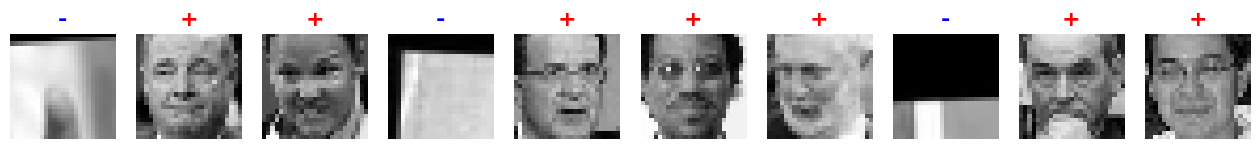

In [5]:
n_show = 10

plt.figure(figsize=(16,4))
for n,i in enumerate(rng.permutation(len(images))[:n_show],start=1):
    img = images[i]
    t,c = ('+','r') if target[i] else ('-','b')
    plt.subplot(1,n_show,n)
    plt.axis(False)
    plt.title(t,color=c,fontdict = {'fontsize':16,'fontweight':'bold'})    
    plt.imshow(img,cmap='gray')

## Haar like feature

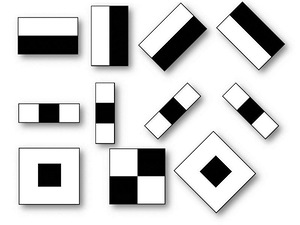

In [6]:
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [7]:
feature_types = ['type-2-x','type-2-y']

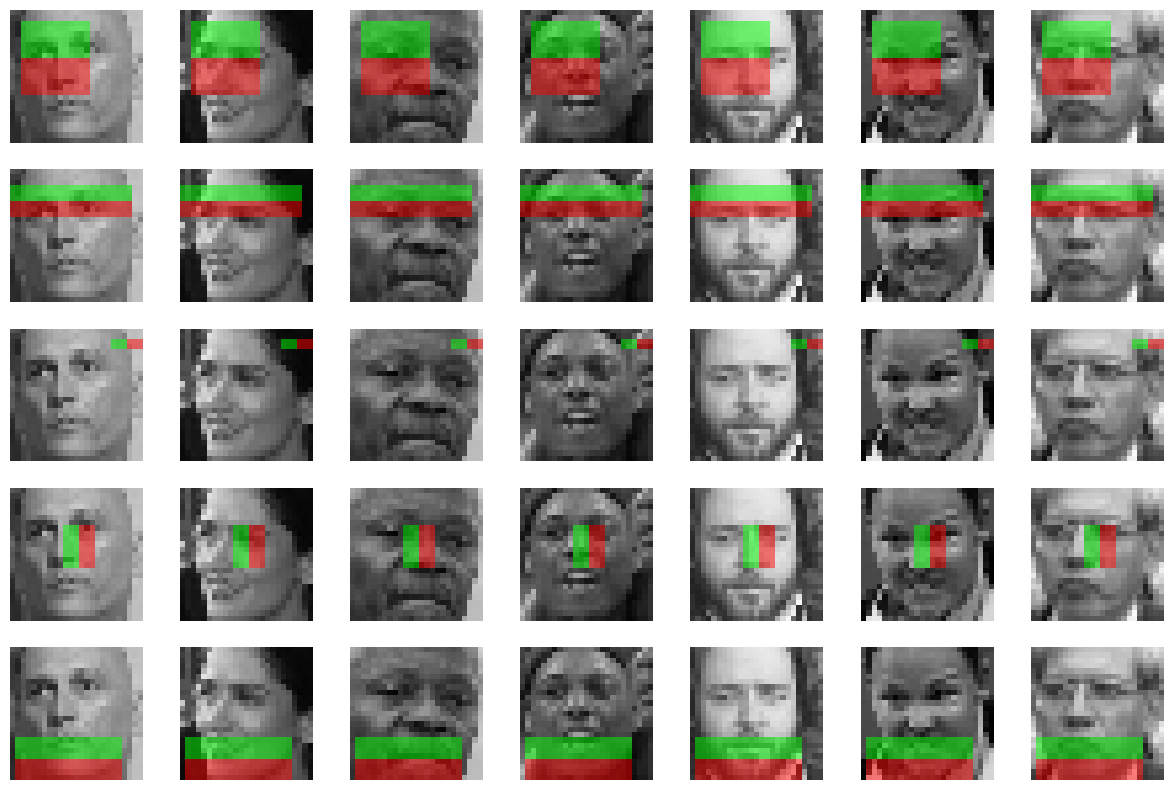

In [8]:
# рисуем примеры Haar like feature
feature_coord, _ = haar_like_feature_coord(width=im_w,height=im_h,feature_type=feature_types)

n_show, n_feat = 7,5

ii = rng.permutation(len(images)//2)[:n_show] # случайно выбираем картинки
idx_sorted = rng.permutation(len(feature_coord)) # случайно выбираем признаки 

plt.figure(figsize=(15,n_feat*2,))
for n,img in enumerate(images[ii],start=1):
    for j in range(n_feat):
        plt.subplot(n_feat,n_show, n+(n_show*j) )
        feat = feature_coord[idx_sorted[j]]
        img_ = draw_haar_like_feature(img,0,0,im_w,im_h,[feat])
        plt.axis(False)
        plt.imshow(img_,cmap='gray')

In [9]:
# количество признаков
len(feature_coord)

101400

---

https://www.mathworks.com/help/images/integral-image.html

**Интегральное изображение** - простой способ найти среднее значение яркости в пределах заданного участка изображения. 

$$ S[i,j] = I[i,j] + S[i-1,j] + S[i,j-1] - S[i-1, j-1] $$



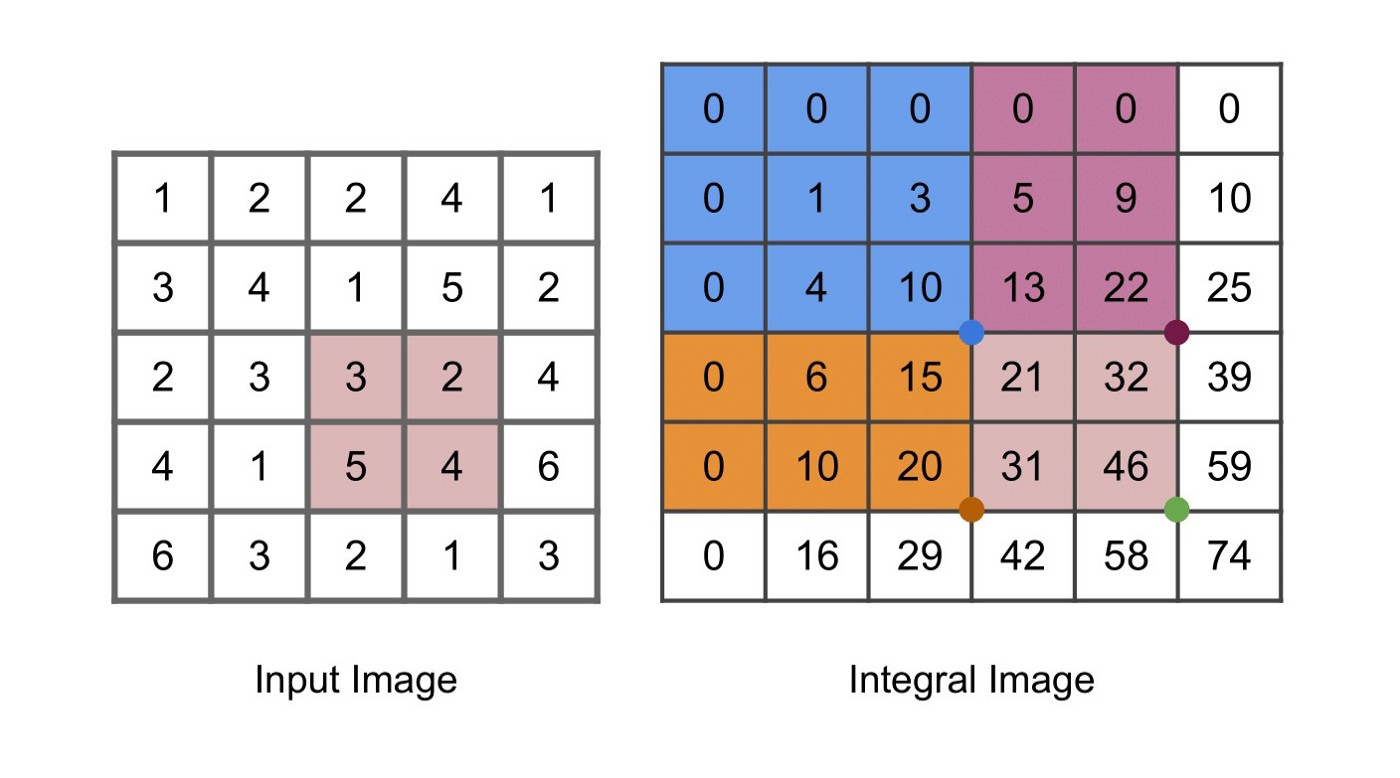

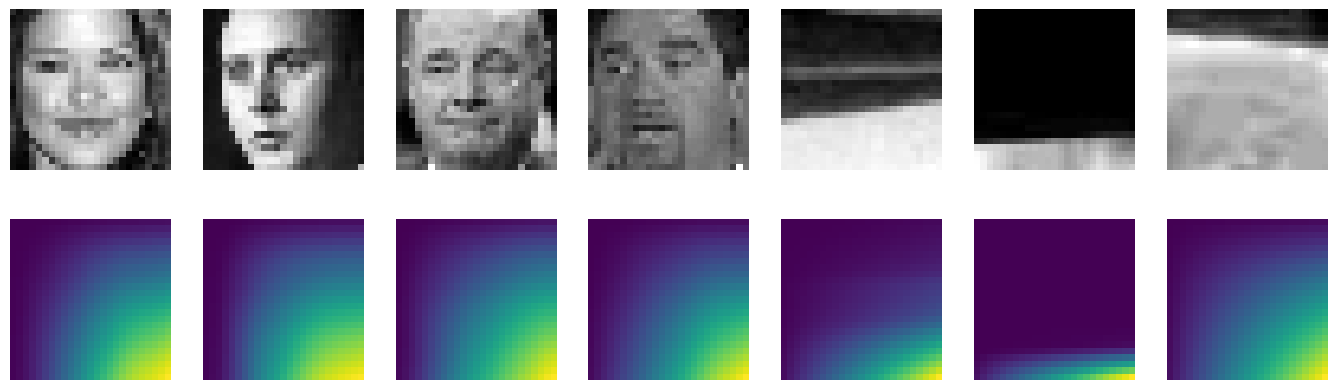

In [10]:
from skimage.transform import integral_image

n_show = 7

fig = plt.figure(figsize=(17,5))
for n,i in enumerate( rng.permutation(len(images))[:n_show] ,start=1):
    img = images[i]
    img_i = integral_image(img)
    # print(n, img.shape, img_i.shape)

    plt.subplot(2,n_show,n)
    plt.axis(False)
    plt.imshow(img,cmap='gray')

    plt.subplot(2,n_show,n+n_show)
    plt.axis(False)
    plt.imshow(img_i) #,cmap='gray')

https://habr.com/ru/post/278435/

Один раз составив интегральную матрицу изображения, можно быстро вычислять сумму значений пикселей любой прямоугольной области в пределах этого изображения.

$$S[A] + S[D] - S[B] - S[C]$$

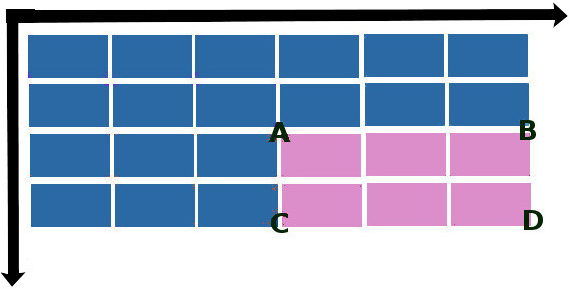

**Вычисление Haar like features из Integral Image**

Используя Integral Image, мы можем добиться постоянной временой оценки.

- Краевые объекты или 2 прямоугольных объекта требуют 6 обращений к памяти.
- Линейные объекты или 3 прямоугольных объекта требуют 8 обращений к памяти.
- Диагональные объекты или 4 прямоугольных объекта требуют 9 обращений к памяти.

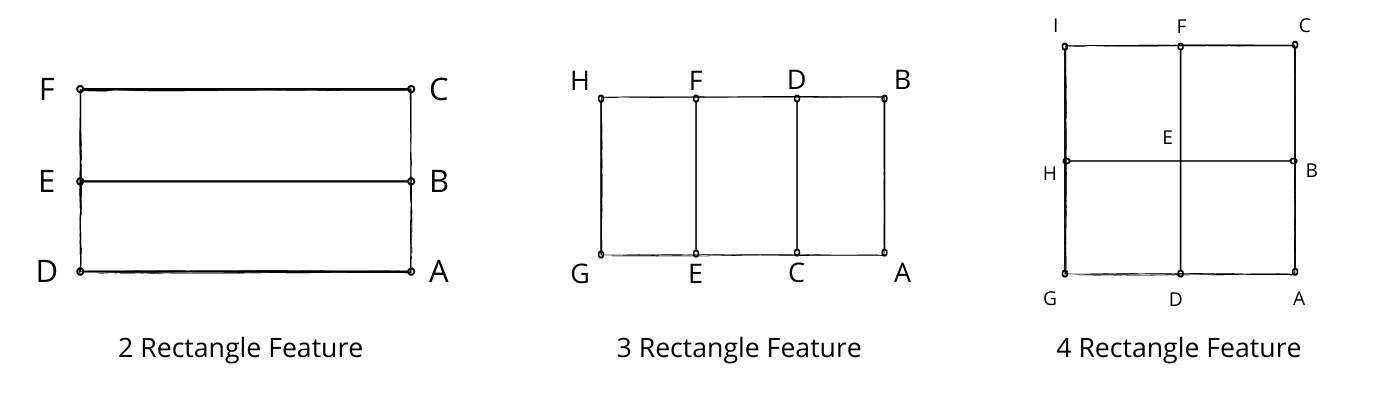

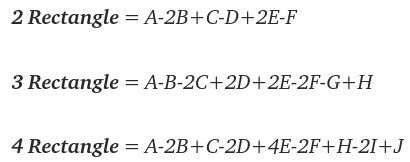

In [11]:
%%time 

# from skimage.transform import integral_image
from skimage.feature import haar_like_feature

X = np.array([
        haar_like_feature(integral_image(img),0,0,im_w,im_h,feature_type=feature_types,)
        for img in tqdm(images) 
    ])

X.shape

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 24.8 s, sys: 177 ms, total: 25 s
Wall time: 24.9 s


(200, 101400)

## обучение модели

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, target, test_size=.33) 
     # train_size=.75, stratify=target)
X_train.shape, X_test.shape

((134, 101400), (66, 101400))

In [13]:
del X
del target

In [14]:
%%time

from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier().fit(X_train, y_train)

/opt/venv/sevgu_1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


CPU times: user 59.9 s, sys: 398 ms, total: 1min
Wall time: 1min


## оценка результатов

In [15]:
from sklearn.metrics import classification_report

o_test = model.predict(X_test)
print(classification_report(y_test,o_test) )

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.94      0.97        31

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66



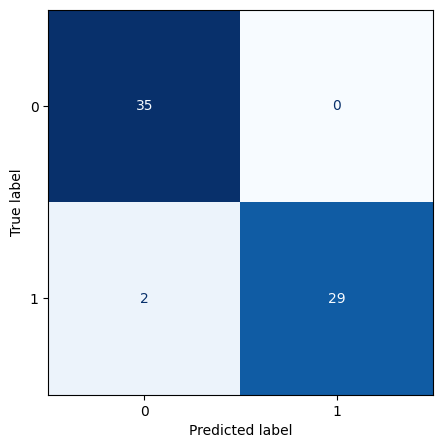

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test,o_test), 
    #display_labels=class_names,
)

disp.plot(ax=ax, include_values=True, cmap='Blues', colorbar=False,)

plt.show()

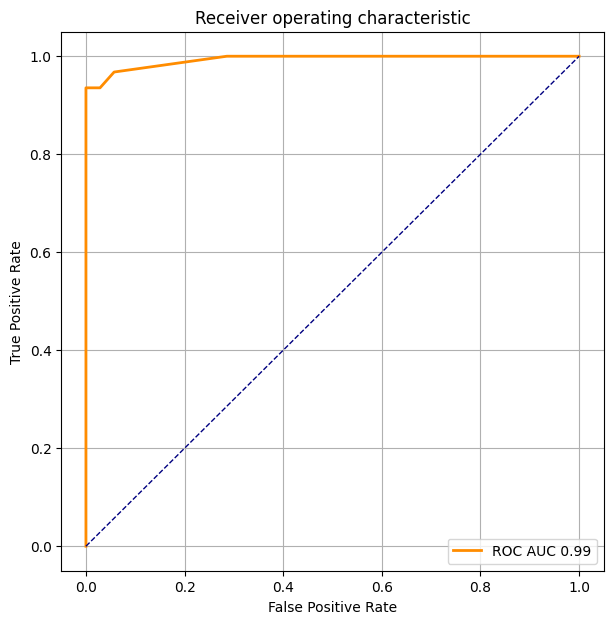

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

s = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve( y_test, s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### наиболее информативные признаки

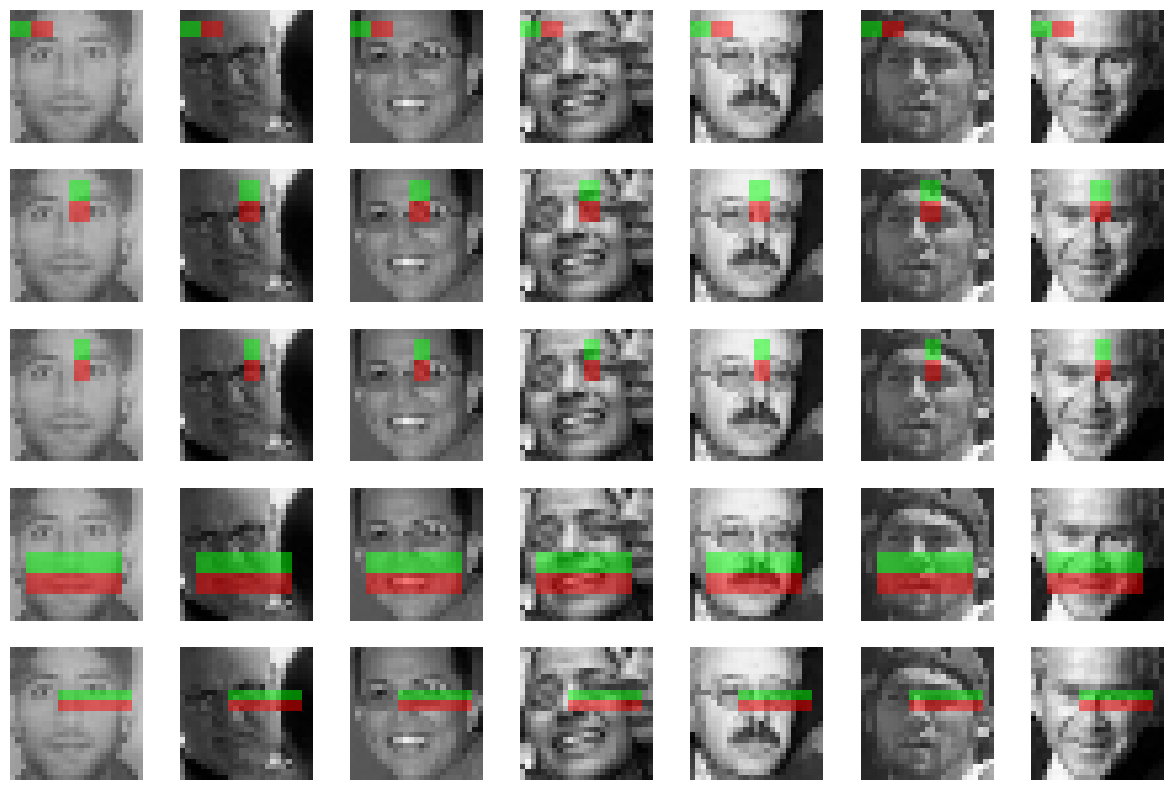

In [18]:
n_show, n_feat = 7,5

ii = rng.permutation(len(images)//2)[:n_show] # случайно выбираем картинки

idx_sorted = np.argsort(model.feature_importances_)[::-1] # наиболее информативные признаки

plt.figure(figsize=(15,n_feat*2,))
for n,img in enumerate(images[ii],start=1):
    for j in range(n_feat):
        plt.subplot(n_feat,n_show, n+(n_show*j) )
        feat = feature_coord[idx_sorted[j]]
        img_ = draw_haar_like_feature(img,0,0,im_w,im_h,[feat])
        plt.axis(False)
        plt.imshow(img_,cmap='gray')